### C1C Jimmy McGoldrick
### CS 471
### PEX 5
### 8 Dec 2021
### Documentation Statement: I used no unauthorized resources.

## 80 Points

In PEX 5 you will train the YOLO object detection algorihtm to detect objects that interest you. If you are not feeling creative, you can collect data and train a model to detect playing card suits and face values. You will then do something interesting with your model. For example, with the playing card data set, you can use the web cam to play blackjack without user input. 

The graded objectives for PEX 5 are:

(10 pts) Collect and label data for use in building a custom YOLO model

(20 pts) Train the YOLO model to high accuracy for your domain

  **"Lt Col Maher, what is high accuracy?" ... It depends on your domain. If you want to make sure you recieve full credit, write down all of your efforts to improve the accuracy of the model, and write a statement why you think you have achieved peak accuracy in this model. Charts and graphs will help to justify your stance. 

(10 pts) Use data analysis to interpret the Mean Average Precision, accuracy and recall of your model

(20 pts) Enable object detection through a web camera

(20 pts) Write code that does something interesting with your model. 

(10 pts) Write a 300-500 word essay describing the possible ethical implications of your project. Reference an ethical framework to justify your view. 


**AUTHORIZED RESOURCES:** Any material from the CS 471 course site and online resources. You may reuse online code as long as you describe what the code is doing in your comments and you modify it to solve this problem. Don't forget to document any online code sources. 

**NOTE:**

*  Never copy another person’s or group’s work and submit it as your own.
*  Do not jointly create a program or complete this assignment unless explicitly allowed.
*   You must document all help received from sources other than your instructor or instructor-provided course materials (including your textbook).

**Documentation Policy:**

*   You must document all help received from any source other than your instructor or instructor-provided materials, including your textbook (unless directly quoting or paraphrasing).
*   The documentation statement must explicitly describe WHAT assistance was provided, WHERE on the assignment the assistance was provided, and WHO provided the assistance, and HOW it was used in completing the assignment.
*   If no help was received on this assignment, the documentation statement must state “None.”
*   If you checked answers with anyone, you must document with whom on which problems. You must document whether or not you made any changes, and if you did make changes you must document the problems you changed and the reasons why.
*   Vague documentation statements must be corrected before the assignment will be graded and will result in a 5% deduction on the assignment.

**Turn-in Policies:**

*   On-time turn-in is at the specific day and time listed above.
*   Post the required solution files to your Github Classroom repo.
*   Only 1 turn-in required per team.






## (10 pts) Task 1 Train and Label data for use in building a custom YOLO model. 
I recommend creating an account with Roboflow.com to upload pictures and label the data set. There are several other tools available that you are welcome to use. If you use another tool, I will need a way to access your data; please provide that method in the text box below. If you use Roboflow, copy and paste the link to your Roboflow project page below.

### I chose to use roboflow to upload and annotate an ASL dictionary, because I think it would be interesting to see computer vision used to create vision-to-speech in the same way that text-to-speech is used to help visually impaired. https://app.roboflow.com/c22james-mcgoldrick-usafa-edu/asl-computer-vision-library

### After creating and annotating my own data set, I found a publicly available ASL object detection library that contains over 750 images -- way more than mine. I used this one to train my model.

### Install Dependencies

In [3]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6
# install dependencies as necessary

import torch
import yaml
import glob

!pip install -qr requirements.txt  # install dependencies (ignore errors)
!pip install -q roboflow

from roboflow import Roboflow
from IPython.display import Image, display
from IPython.core.magic import register_line_cell_magic
from IPython.display import Image, clear_output  # to display images
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5
HEAD is now at 886f1c0 DDP after autoanchor reorder (#2421)
Setup complete. Using torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


### Download Dataset from Roboflow

In [ ]:
#follow the link below to get your download code from from Roboflow
rf = Roboflow(model_format="yolov5", notebook="roboflow-yolov5")
%cd /content/yolov5
rf = Roboflow(api_key="L9xEJjvMffR584Ifmbzo")
#project = rf.workspace().project("asl-computer-vision-library")
project = rf.workspace().project("american-sign-language-letters-hngay")
dataset = project.version(1).download("yolov5")


upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=roboflow-yolov5
/content/yolov5
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to American-Sign-Language-Letters-1 in yolov5pytorch:: 100%|██████████| 1451/1451 [00:01<00:00, 1158.58it/s]


## (20 pts) Task 2 Train a Yolo model to high accuracy. 

Keep a log of your experimentation with improving your model. 

### Define the Model

In [ ]:
# define number of classes based on YAML
with open(dataset.location + "/data.yaml", 'r') as stream: num_classes = str(yaml.safe_load(stream)['nc'])
print(num_classes + " potential detection classes")

#customize iPython writefile so we can write variables
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

26 potential detection classes


#### Write out a template to base the model from

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

### Train the Model

In [ ]:
# train yolov5s on custom data
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 8 --epochs 1 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights /content/yolov5/weights/best.pt --name yolov5s_results  --cache --exist-ok

#save weights
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/yolov5/weights

### Log Performance and Training

I trained this model for chunk of 100 epochs at a time, and saved over the previous best.pt file for use as the starting weights of the next chunk each time.

1. 0-99: 32% MAP
2. 100-199: 68% MAP
3. 200-299: 84% MAP
4. 300-399: 89% MAP

Once I had reached 400 epochs, the MAP started to level off, so I ran one final chunk of 100 epochs, this time with a batch size of 8 instead of 16.

5. 400-499: 92% MAP

### Run Inference Model 

In [ ]:
# use the best weights!
!python detect.py --weights /content/yolov5/weights/best.pt --img 416 --conf 0.2 --source /content/yolov5/American-Sign-Language-Letters-1/test/images --name /content/yolov5/runs/detect/output

## (20 pts) Task 3 Justify how well your model performs
Provide charts showing at least the Mean Average Precision, Accuracy, and Recall of your model. Discuss the charts and what these results mean. You may want to include a discussion on overfitting and underfitting in your discussion. 

### Visualize starting Data

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/test_batch0_labels.jpg', width=900)

### Visualize Results

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above
for imageName in glob.glob('/content/yolov5/runs/detect/output/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

### Evaluate the Model with Tensorboard

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

### Answer to Task 3. Add any discussion of your models to this box. 

## (20 pts) Task 4. Connect your model to Webcam streaming

Enable your model to predict in real-time on a web camera, using your custom model.
Hint: On the left hand side, Google Colab gives you code for accessing your webcam with Javascript. Use this code to get your webcam working. This will not be the same as real-time webcam footage, but it will get you as close as you can get on Google Colab. To execute this step

1.   Modify the webcam code so that it will open the webcam,
2.   take a picture,
1.   close the webcam,
2.   run the detection algorithm,
1.   display the detection image
2.   and then repeat 5 times.


### Create the take_photo() method

In [1]:
def take_photo(filename='webcamPhoto.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

### Take 5 webcam photos and define them

<IPython.core.display.Javascript object>

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.2, device='', exist_ok=True, img_size=416, iou_thres=0.45, name='/content/yolov5/runs/detect/webcam', project='runs/detect', save_conf=False, save_txt=False, source='webcamPhoto.jpg', update=False, view_img=False, weights=['/content/yolov5/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 232 layers, 7313943 parameters, 0 gradients, 17.0 GFLOPS
image 1/1 /content/yolov5/webcamPhoto.jpg: 320x416 1 K, Done. (0.026s)
Results saved to /content/yolov5/runs/detect/webcam
Done. (0.046s)


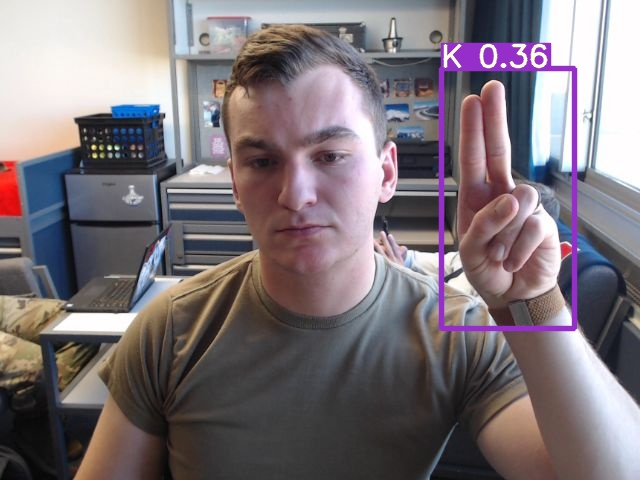

<IPython.core.display.Javascript object>

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.2, device='', exist_ok=True, img_size=416, iou_thres=0.45, name='/content/yolov5/runs/detect/webcam', project='runs/detect', save_conf=False, save_txt=False, source='webcamPhoto.jpg', update=False, view_img=False, weights=['/content/yolov5/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 232 layers, 7313943 parameters, 0 gradients, 17.0 GFLOPS
image 1/1 /content/yolov5/webcamPhoto.jpg: 320x416 1 J, 1 K, 1 O, 1 R, 1 X, Done. (0.026s)
Results saved to /content/yolov5/runs/detect/webcam
Done. (0.043s)


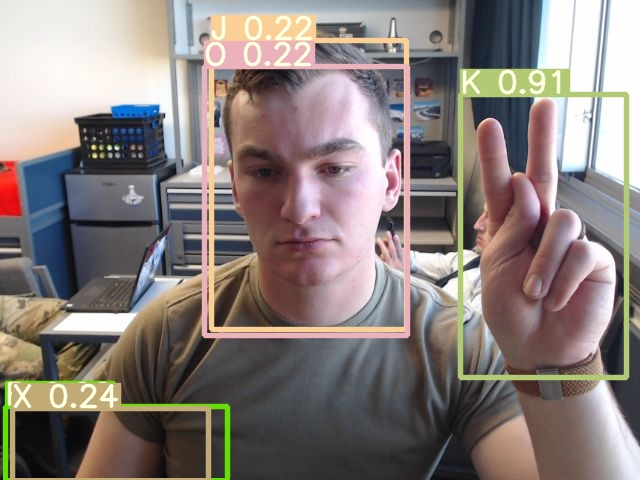

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [5]:
for i in range(5):
  try:
    filename = take_photo()
    # run the inference model on the image
    !python detect.py --weights /content/yolov5/weights/best.pt --img 416 --conf 0.2 --source webcamPhoto.jpg --name /content/yolov5/runs/detect/webcam --exist-ok
    # print the detection image
    display(Image(filename='/content/yolov5/runs/detect/webcam/webcamPhoto.jpg'))
    print("\n")
    
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not grant the page permission to access it.
    print(str(err))

print("complete")

## (10 pts) Task 5. Create something interesting using your model

You have a limited time, so don't make this a huge feature, just something cool your model could do. For example, something that counts the objects coming across the webcam would receive full points. If you have a more creative idea, I may be inclined to add some bonus points, but make sure you are taking care of your other classwork as well. 

### For my Task 5, I chose to write the beginning of an ASL translator, that takes images being shown to the webcam and outputs a translation in text. Note that ASL is usual spoken one word at a time, not by letters, so more usuable versions would need to be trained on a complete ASL dictionary.

### Define an exit_translator function that has a done button

### Print output to get the user started, capture one sign at a time and print text detections

In [11]:
print("click the capture button to take a picture of each letter. The translation will be output below.\n")

done = "n"
word = "Word: "

while done is not "y":
  filename = take_photo()
  !python detect.py --weights /content/yolov5/weights/best.pt --img 416 --conf 0.2 --source webcamPhoto.jpg --project /content/yolov5/runs/detect/translation --exist-ok --save-txt
  with open('/content/yolov5/runs/detect/translation/exp/labels/webcamPhoto.txt') as f:
    word = word + f.readline()
  done = input("done? (y/n)")

print("Collection finished." + word)


click the capture button to take a picture of each letter. The translation will be output below.



<IPython.core.display.Javascript object>

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.2, device='', exist_ok=True, img_size=416, iou_thres=0.45, name='exp', project='/content/yolov5/runs/detect/translation', save_conf=False, save_txt=True, source='webcamPhoto.jpg', update=False, view_img=False, weights=['/content/yolov5/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 232 layers, 7313943 parameters, 0 gradients, 17.0 GFLOPS
image 1/1 /content/yolov5/webcamPhoto.jpg: 320x416 1 K, Done. (0.026s)
Results saved to /content/yolov5/runs/detect/translation/exp
1 labels saved to /content/yolov5/runs/detect/translation/exp

## (10 pts) Task 6. Write 300-500 words on the ethical implications of your project
Make sure you support your thoughts with ethical frameworks from ACM, IEEE, or any other reputible source. 

>There are very interesting ethical considerations with all Machine Learning and Artificial Intelligence applications, but I think that translation brings up some very interesting concerns. At the surface level, this is a very moral application of computer science, because it is using computer vision to help people who communicate in different ways understand each other. This is in line with the ACM code of ethics principle 1.1, “Contribute to society and to human well-being”.  Additionally, helping different kinds of people get equal opportunities relates to principle 1.4, “Be fair and take action not to discriminate”. Therefore, the overall mission of vision-to-text and vision-to-speech translation is based on morally sound principles of contributing to society and helping others.

>However, there are many places where this goal could potentially go wrong. One potential misstep would be to record use of the translator to create new test cases for online learning. This could very easily be seen as a good idea because it creates more training data to help continually improve the application and make it better for users. If individuals to do not volunteer this data for use in training, or do not have any way of using the application without being required to have their use recorded, this is a clear violation of principles 1.6 and 1.7, “respect privacy”, and “honor confidentiality”.

>Additionally, consider the general practice in machine learning that models are never left solely in charge of making a classification or decision in a situation; there is always a human somewhere behind the model verifying its decisions. For the same reasons, adding another human monitoring someone’s conversations through the translator would be a breach of privacy. Yet, eliminating this verification layer means that it is only likely that the translator makes a mistake (especially because ASL is an extremely contextual language) and puts words into someone’s mouth, which is a violation of principle 2.1 “Strive to achieve high quality in both the processes and products of professional work” because a translator that does not output what the person is saying is objectively low quality work.

>Ultimately, given these considerations I believe that the most ethically sound application for this application would be to assist or replace an ASL interpreter on TV, where the content being communicated is publicized and therefore there exists no reasonable expectation of privacy. 
